<a href="https://colab.research.google.com/github/merajsiddieque/ML-Lab/blob/main/ML_Lab_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML/Datasets/Iris.csv")
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [4]:
# Encode target
le = LabelEncoder()
df['Species_encoded'] = le.fit_transform(df['Species'])

In [62]:
X = df[['SepalLengthCm', 'SepalWidthCm']]
y = df['Species_encoded']


In [63]:
# Train, validation, test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [64]:
df_0 = df[df['Species_encoded'] == 0]
df_1 = df[df['Species_encoded'] == 1]
df_2 = df[df['Species_encoded'] == 2]

In [65]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Scale features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

# Multi-class Logistic Regression
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)
model.fit(X_train_s, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=200, multi_class='multinomial')

In [66]:
def predict_classes(X_scaled):
    preds = model.predict(X_scaled)
    preds_round = np.rint(preds).astype(int)  # round to nearest integer
    preds_round = np.clip(preds_round, y.min(), y.max())  # keep 0,1,2 only
    return preds_round

y_pred_test = predict_classes(X_test_s)
print(y_pred_test)

[0 2 2 0 2 1 2 2 1 0 0 2 1 0 2]


In [67]:
def precision_recall_f1(y_true, y_pred, average=None):
    classes = np.unique(y_true)
    precisions, recalls, f1s, supports = [], [], [], []

    for c in classes:
        tp = np.sum((y_pred == c) & (y_true == c))
        fp = np.sum((y_pred == c) & (y_true != c))
        fn = np.sum((y_pred != c) & (y_true == c))

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        supports.append(np.sum(y_true == c))

    precisions, recalls, f1s, supports = map(np.array, [precisions, recalls, f1s, supports])

    if average == "macro":
        return np.mean(f1s)
    elif average == "micro":
        tp = np.sum(y_true == y_pred)
        total = len(y_true)
        return tp / total
    elif average == "weighted":
        return np.sum(f1s * supports) / np.sum(supports)
    else:
        return f1s



In [68]:
y_pred_test = predict_classes(X_test_s)

f1_macro = precision_recall_f1(y_test, y_pred_test, average="macro")
f1_micro = precision_recall_f1(y_test, y_pred_test, average="micro")
f1_weighted = precision_recall_f1(y_test, y_pred_test, average="weighted")

print("Macro F1     :", f1_macro)
print("Micro F1     :", f1_micro)
print("Weighted F1  :", f1_weighted)


Macro F1     : 0.5833333333333334
Micro F1     : 0.6
Weighted F1  : 0.5833333333333334


In [69]:
# Get predicted probabilities
y_prob_test = model.predict_proba(X_test_s)  # shape: (n_samples, n_classes)


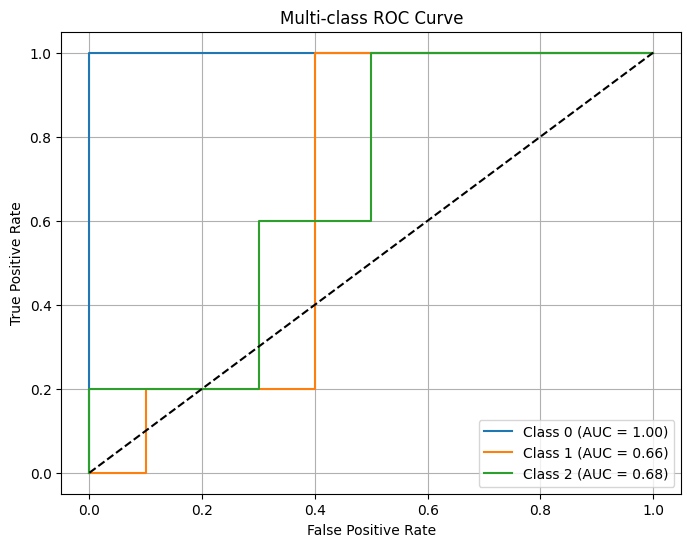

In [70]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Convert y_test to one-hot for multi-class ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Plot ROC curves for each class
plt.figure(figsize=(8,6))

for i in range(n_classes):
    fpr, tpr, thresholds = roc_curve(y_test_bin[:, i], y_prob_test[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot random chance line
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [52]:
# %% [code]
# Add bias (intercept)
X_b = np.hstack([np.ones((X.shape[0], 1)), X])

# Normal Equation
theta = np.linalg.pinv(X_b.T @ X_b) @ (X_b.T @ y)

# Predictions
y_pred = X_b @ theta

# Metrics
MAE = np.mean(np.abs(y - y_pred))
MSE = np.mean((y - y_pred) ** 2)
R2  = 1 - np.sum((y - y_pred) ** 2) / np.sum((y - np.mean(y)) ** 2)

print("=== Linear Regression with Normal Equation ===")
print("Theta (coefficients):", np.round(theta, 6))
print(f"Mean Absolute Error (MAE): {MAE:.6f}")
print(f"Mean Squared Error (MSE): {MSE:.6f}")
print(f"R² Score: {R2:.6f}")

# Show sample predictions
print("\nFirst 10 samples: (y_true, y_pred_float, y_pred_rounded)")
for i in range(10):
    print(int(y[i]), f"{y_pred[i]:.4f}", int(np.rint(y_pred[i])))


=== Linear Regression with Normal Equation ===
Theta (coefficients): [-1.360584  0.737651 -0.638427]
Mean Absolute Error (MAE): 0.335328
Mean Squared Error (MSE): 0.183192
R² Score: 0.725213

First 10 samples: (y_true, y_pred_float, y_pred_rounded)
0 0.1669 0
0 0.3386 0
0 0.0634 0
0 0.0535 0
0 0.0293 0
0 0.1329 0
0 -0.1380 0
0 0.1570 0
0 0.0336 0
0 0.2748 0
